In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV, Ridge, Lasso, ElasticNet, Lars, SGDRegressor, PassiveAggressiveRegressor, Perceptron
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, KFold, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectPercentile, f_regression, SelectKBest, mutual_info_regression, RFE, SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesClassifier

DATASET_PATH = "dataset/"

def load_song_data(dataset_path=DATASET_PATH):
    df = pd.read_csv(dataset_path + 'year-prediction-msd-train.txt', sep=",", header=None)
    return df

In [2]:
def iter_minibatches(chunksize, x_train, y_train):
    chunkstartmarker = 0
    while chunkstartmarker < len(x_train):
        x_chunk = x_train[chunkstartmarker:chunkstartmarker+chunksize]
        y_chunk = y_train[chunkstartmarker:chunkstartmarker+chunksize]
        yield x_chunk, y_chunk
        chunkstartmarker += chunksize

In [3]:
def training (chunksize, x_train, y_train, regr):
    batcherator = iter_minibatches(chunksize=chunksize, x_train=x_train, y_train=y_train)
    
    for x_chunk, y_chunk in batcherator:
        if(len(x_chunk)!=0):
            regr.named_steps['regr'].partial_fit(x_chunk, y_chunk)
    return regr

In [4]:
def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s*%s" % (round(coef, 3), name)
                                   for coef, name in lst)

In [5]:
#songs é um DataFrame
songs = load_song_data()

In [6]:
songs_x = songs.iloc[:,1:]
songs_y = songs.iloc[:,0]

In [7]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('skb', SelectKBest(f_regression, k=90)),#Fazer um gráfico variando mean-squared-error | k. Ate agora 80 é o melhor
    #('rfe',RFE(Ridge(), n_features_to_select=30)),
    #('lasso', RandomizedLasso(alpha=1)),
    #('sfm', SelectFromModel(LassoCV(), threshold='1.25*mean')),
    #('etc', ExtraTreesClassifier())
])
songs_x = num_pipeline.fit_transform(songs_x, songs_y.ravel())

## Prepare the regretion model

In [8]:
regr = Pipeline([
            ("features", PolynomialFeatures(degree=1)),
#            ("regr", SGDRegressor()),
            ("regr", LinearRegression())
         ])
#penalty='l1', loss='squared_epsilon_insensitive', learning_rate='invscaling', l1_ratio=0.75, eta0=0.001, epsilon=1e-09, alpha=1e-06

#regr = make_pipeline(PolynomialFeatures(1), Ridge(alpha=1e-6, fit_intercept=True, max_iter=1e9, solver='auto', tol=1e-6))
#Lasso é complexo, se der tempo tento olhar ele melhor
#regr = make_pipeline(PolynomialFeatures(1), Lasso(alpha=1e-6, fit_intercept=True, max_iter=1e3, tol=1e-9, positive=False, selection='random', warm_start=True))
#regr = make_pipeline(PolynomialFeatures(1), ElasticNet(alpha=1e-6, l1_ratio=0.75, fit_intercept=True, max_iter=1e6, tol=.1, positive=False, selection='cyclic', warm_start=False, precompute= True))
#regr = make_pipeline(PolynomialFeatures(1), SGDRegressor(verbose=True,fit_intercept=True, power_t=0.5, penalty='l1', loss='squared_loss', learning_rate='constant', l1_ratio=0.75, eta0=0.001, epsilon=0.1, alpha= 0.001))
#regr = make_pipeline(PolynomialFeatures(1), PassiveAggressiveRegressor(verbose=True,fit_intercept=True, loss='squared_epsilon_insensitive', epsilon=0.001, C=0.001))

X_ = regr.named_steps["features"].fit_transform(songs_x)
print("n_input_features_: ", regr.named_steps['features'].n_input_features_)
print("n_output_features_:", regr.named_steps["features"].n_output_features_)


n_input_features_:  90
n_output_features_: 91


## Strategy to slipt train and test sets
## Categorize and splits ramdom representative sets (StratifiedShuffleSplit)
Similar percentage of data in each category

In [9]:
#Generates 5 categories of year (size: 18 years)
n_cat=5
size=(np.max(songs_y)-np.min(songs_y)+1)/(n_cat) #+1 avoid category 0.0 -> otherwise  would be made only by min values
songs["year_cat"] = np.ceil((songs_y-np.min(songs_y)+1) / size) 

In [10]:
#Distribution of data in categories
dist=songs["year_cat"].value_counts()/len(songs)
print(dist)

5.0    0.770044
4.0    0.172138
3.0    0.052429
2.0    0.004434
1.0    0.000955
Name: year_cat, dtype: float64


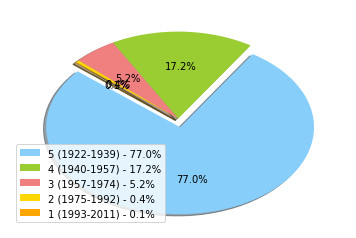

In [11]:
labels=["5 (1922-1939) - 77.0%", "4 (1940-1957) - 17.2%", "3 (1957-1974) - 5.2%", "2 (1975-1992) - 0.4%", "1 (1993-2011) - 0.1%"]
#labels = range (1,6)
sizes = dist
colors = ['lightskyblue', 'yellowgreen', 'lightcoral', 'gold', 'orange']
explode = (0.1, 0, 0, 0, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, colors=colors, labels=None,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(loc='lower left', labels=labels)

In [14]:
n_splits=10
split = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=1)
rmse_scores = list()
r2_scores = list()

#sum of scores for each category -> the goal is to calculate mean error by category
sum_rmse_cat=[]
for i in range(0, n_cat):
    sum_rmse_cat.append(0)
    
#Representative test sets (equal percentage of data in each category)
for train_index, test_index in split.split(X_, songs["year_cat"]):
    strat_songs_x_train, strat_songs_x_test = X_[train_index], X_[test_index]
    strat_songs_y_train, strat_songs_y_test = songs_y[train_index], songs_y[test_index]
    
    #Train and execute the model
    regr.named_steps['regr'].fit(strat_songs_x_train, strat_songs_y_train)
    songs_y_pred = regr.named_steps['regr'].predict(strat_songs_x_test)
    songs_y_pred = songs_y_pred.round()

    #compute scores
    rmse_scores.append(np.sqrt(mean_squared_error(strat_songs_y_test, songs_y_pred)))
    r2_scores.append(r2_score(strat_songs_y_test, songs_y_pred))

    #compute score by category
    re_songs_y_test=strat_songs_y_test.values.reshape(-1,1)
    for i in range(1, n_cat+1):
        if (i==1):
            index=np.where(np.ceil((strat_songs_y_test-np.min(songs_y)) / size)<=i) #avoid category 1
        else:
            index=np.where(np.ceil((strat_songs_y_test-np.min(songs_y)) / size)==i)
        y_test=re_songs_y_test[index]
        y_pred=songs_y_pred[index]
        sum_rmse_cat[i-1]=sum_rmse_cat[i-1]+np.sqrt(mean_squared_error(y_test, y_pred))

In [15]:
def display_scores(scores):
    print("Mean:", sum(scores)/float(len(scores)))

In [16]:
display_scores(rmse_scores)
display_scores(r2_scores)

Mean: 9.55886292248
Mean: 0.236419364007


In [17]:
print("RMSE scores by category")
for i in range (0, n_cat):
    print("Category ", i+1, "=", sum_rmse_cat[i]/n_splits)

RMSE scores by category
Category  1 = 56.9210333288
Category  2 = 37.5289704845
Category  3 = 24.3735910803
Category  4 = 9.07221038821
Category  5 = 6.50893302638


In [18]:
#Checking if the test set has same distribution in categories compared to the entire dataset (songs)
strat_songs_x_test=np.insert(strat_songs_x_test, 0, np.ceil((strat_songs_y_test-np.min(songs_y)+1) / size), axis=1)
cat, count = np.unique(strat_songs_x_test[:,0], return_counts=True)
count/len(strat_songs_x_test)

array([ 0.00094885,  0.00444234,  0.05242388,  0.17212973,  0.77005521])

[6.508933026379947, 9.0722103882125484, 24.373591080300184, 37.528970484466484, 56.921033328789733]


<Container object of 5 artists>

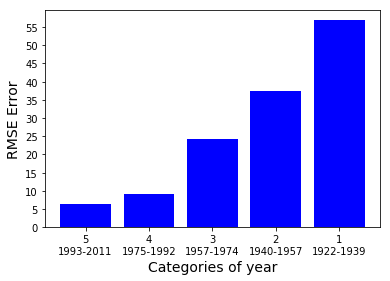

In [19]:
#Plot graph error by category
mean=[0,0,0,0,0]
cont=0
for i in range (n_cat-1, -1, -1):
    mean[i]=sum_rmse_cat[cont]/n_splits
    cont=cont+1
print(mean);
    
plt.ylabel("RMSE Error", fontsize=14, )
plt.xlabel("Categories of year", fontsize=14, )
plt.xticks(range(1,n_cat+1), ['5\n1993-2011', '4\n1975-1992', '3\n1957-1974', '2\n1940-1957','1\n1922-1939'])
plt.yticks(range(0,60,5))
plt.bar(range(1,n_cat+1), mean, color="blue")

## Cross validation - Kfold strategy

In [20]:
n_splits=10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1) #define n groups
rmse_scores = list()
r2_scores = list()

#for each par (train,test) in slip -> train, test and compute error
#inwhich train has k-1 groups test 1 group
for train_index, test_index in kf.split(X_):    
    songs_x_train, songs_x_test = X_[train_index], X_[test_index]
    songs_y_train, songs_y_test = songs_y[train_index], songs_y[test_index]
 
    #train and execute the model
    #regr=training(1000, songs_x_train, songs_y_train, regr)
    regr.named_steps['regr'].fit(songs_x_train, songs_y_train)
    #songs_y_pred = regr.predict(songs_x_test)
    songs_y_pred = regr.named_steps['regr'].predict(songs_x_test)
    songs_y_pred = songs_y_pred.round()

    
    #compute scores
    rmse_scores.append(np.sqrt(mean_squared_error(songs_y_test, songs_y_pred)))
    r2_scores.append(r2_score(songs_y_test, songs_y_pred))

In [21]:
display_scores(rmse_scores)
display_scores(r2_scores)

Mean: 9.56003281543
Mean: 0.236302583797


In [22]:
print('Features: ', songs_x_train.shape[1])
print(regr.named_steps['regr'].coef_.shape[0], 'Coenficientes: ', regr.named_steps['regr'].coef_)
print('Estimated intercept: ', regr.named_steps['regr'].intercept_)

print("Linear model:", pretty_print_linear(regr.named_steps['regr'].coef_, regr.named_steps['features'].get_feature_names()))

print('Params: ',regr.named_steps['regr'].get_params())

Features:  91
91 Coenficientes:  [  5.36787761e-19   5.32433258e+00  -2.89562103e+00  -1.53881749e+00
   8.41155673e-02  -3.53125815e-01  -2.84695581e+00  -1.11199996e-01
  -8.36405242e-01  -7.30448388e-01   1.66530853e-01  -7.21582831e-01
  -1.57117860e-02   1.05827688e+00   6.20469575e-01  -5.46019508e-01
   6.82052272e-01   1.99944520e-01   8.34380929e-01   6.15399105e-01
   6.79659239e-01   1.57418004e-01  -9.45257774e-02   1.42842905e+00
   4.18471022e-01  -4.35707871e-01   2.85053229e-02   8.72939568e-01
   1.08746265e-01   1.35669748e-01  -5.59236062e-02  -1.21944362e-01
  -1.07091145e-01  -4.20877028e-01   1.25742949e-01   5.85594533e-02
  -5.62731338e-01  -1.16560410e-01   3.04986828e-01   3.59811591e-01
  -3.59641300e-01  -2.46205784e-01  -1.03177925e-01  -1.07392737e-01
  -8.36043674e-02  -1.40397912e-01   3.67790747e-01   2.29970481e-01
  -5.45382873e-01   7.03124279e-02   2.50447330e-01  -1.17722613e-02
  -1.35946867e-01   1.30675501e-01  -6.27826402e-04  -2.06778784e-02
 